In [1]:
import sys
sys.path.append('..')
%env WORKDIR ~/Documents/weatherpy-work

env: WORKDIR=~/Documents/weatherpy-work


In [2]:
import pandas as pd
from shapely.geometry import Polygon

def load_chase_alley():
    bdys_df = pd.read_csv('chasealley.csv')
    # depending on the version of shapely, we might have to manually close the polygon
    bdys_df = bdys_df.append(bdys_df.loc[0])
    latlon_mat = bdys_df[['lat', 'lon']].as_matrix()
    return bdys_df, Polygon(latlon_mat)

In [3]:
from wxdata import stormevents

df = stormevents.tornadoes('1996-01-01 00:00', '2016-12-31 23:59', tz='CST',
                          hours=range(12, 24), 
                          months=['April', 'May', 'June'])

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))


In [4]:
df.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [5]:
bdys_df, chase_alley = load_chase_alley()
chaseable_tors = stormevents.filter_region(df, chase_alley)

In [6]:
chaseable_tors.head()

,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,end_range,end_azimuth,end_location,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source
1,199605,22,1915,199605,22,1920,2033924,5556025,COLORADO,8.0,...,19.0,N,LAIRD,40.37,-102.10,40.37,-102.10,TORNADO TOOK DOWN SEVERAL POWER POLES AND DAMA...,NaN,PDC
3,199605,31,2013,199605,31,2014,2053076,5579344,TEXAS,48.0,...,6.0,E,CLARENDON,34.93,-100.82,34.93,-100.80,ARES Storm Spotters reported a brief tornado t...,NaN,PDC
4,199605,22,1930,199605,22,1930,2035430,5554505,NEBRASKA,31.0,...,2.0,NE,MILFORD,40.78,-97.02,40.78,-97.02,A shed was destroyed 11/4 miles east of Superi...,NaN,PDC
5,199605,31,1817,199605,31,1818,2053066,5579333,TEXAS,48.0,...,5.0,E,CLAUDE,35.12,-101.30,35.12,-101.28,ARES Storm Spotters reported a brief tornado t...,NaN,PDC
6,199606,23,1430,199606,23,1430,2039266,5562050,NEBRASKA,31.0,...,10.0,S,LOUISVILLE,40.85,-96.15,40.85,-96.15,A tornado briefly touched down on Hwy 50 in Ca...,NaN,PDC


In [7]:
len(chaseable_tors)

6989

In [8]:
from wxdata.plotting import simple_basemap
from wxdata.stormevents import tors

def chase_alley_map(hwys=False):
    layers = ['coastlines', 'countries', 'states', 'counties']
    if hwys:
        layers.append('highways')
    return simple_basemap(proj='merc', bbox=(-110.5, -87, 28, 50), draw=layers)

def plot_tors_on_chase_alley(tornadodata, color='brown', hwys=True, linewidth=2):
    m = chase_alley_map(hwys)
    tors.plot_tornadoes(tornadodata, m, linewidth=linewidth, color=color)
    return m

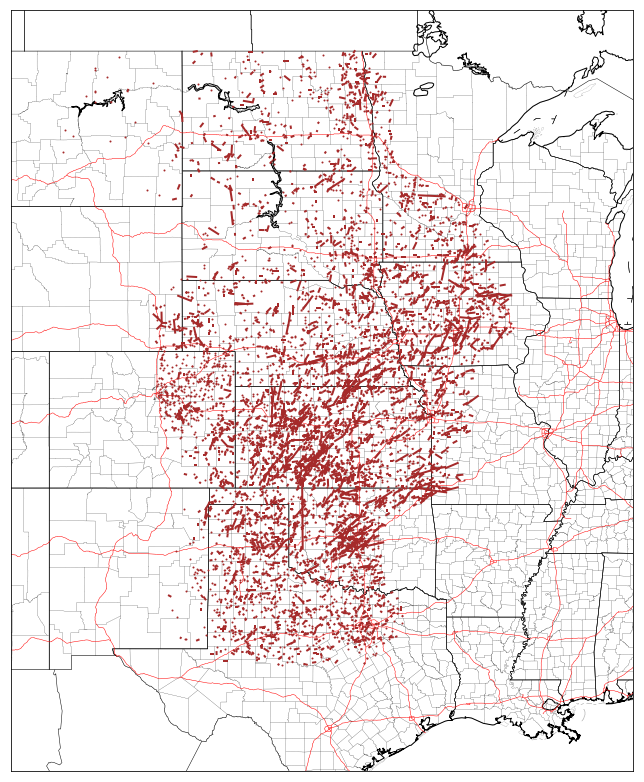

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 14))

plot_tors_on_chase_alley(chaseable_tors, color='brown')

In [32]:
from wxdata.utils import datetime_buckets

def buckets_for_year(year):
    t1 = pd.Timestamp(year=year, month=4, day=1, hour=0, minute=0)
    t2 = pd.Timestamp(year=year, month=7, day=1, hour=0, minute=0)
    return datetime_buckets(t1, t2, dt=pd.Timedelta('1 day'), tz='CST')

In [33]:
from wxdata.extras import st_clusters
from wxdata.stormevents import filter_on_date

def clusters_for_year(year):
    ret = {}
    for bucket in buckets_for_year(year):
        start, end = bucket
        datetors = filter_on_date(chaseable_tors, start, tz='CST')
        
        dateclusts = st_clusters(datetors, eps_km=60, eps_min=60, min_samples=15)
        if dateclusts:
            ret[start] = dateclusts
            
    return ret

In [48]:
from wxdata.plotting import LegendBuilder

def plot_cluster_groups(clust_groups, buckets, cmap='viridis', hwys=True, linewidth=2, **kwargs):
    buckets = list(buckets)
    m = chase_alley_map(hwys)
    
    all_tors = []
    for clust_group in clust_groups:
        for clust in clust_group.clusters:
            clust_tors = clust.events
            all_tors.append(clust_tors)
            
    leg = LegendBuilder(loc=2)
    tors.plot_time_progression(pd.concat(all_tors), m, buckets, cmap=cmap, linewidth=linewidth, legend=leg, 
                               legend_handle_func=lambda bucket_start, bucket_end: bucket_start.strftime('%b %d'),
                              **kwargs)

In [46]:
analyze_year = 2010
results = clusters_for_year(analyze_year)

Text(0.5,1,'2010 Chaseable Tornado Clusters')

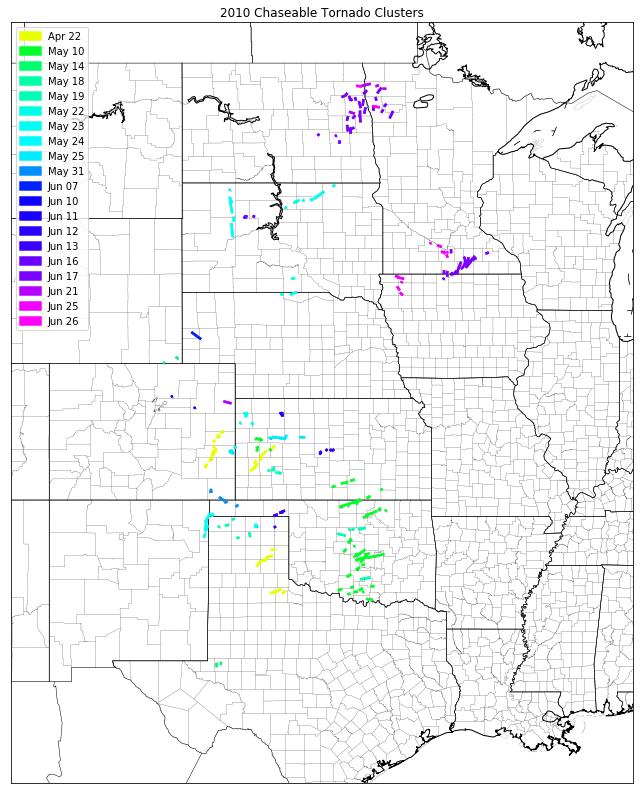

In [51]:
from matplotlib import patheffects
fig = plt.figure(figsize=(14, 14))
plot_cluster_groups(results.values(), buckets_for_year(analyze_year), cmap='gist_rainbow', hwys=False, linewidth=2.5, 
                    patheffect=patheffects.withSimplePatchShadow((1, -1)))
plt.title('{} Chaseable Tornado Clusters'.format(analyze_year))